In [73]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re, sys
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from xgboost import XGBClassifier

%matplotlib inline

In [2]:
sys.path.append('../Andrew')
from utils import evaluate

In [3]:
df = pd.read_csv('../../Data/bird_dataset.csv', index_col=0)

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (40) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# Dropping columns with null values
bird_df = df.drop(columns=['SpecID', 'IOCOrder', 'BLFamilyLatin', 'BLFamilyEnglish', 'BLFamSequID', 'Taxo', 
                      'Scientific', 'English', 'Diet-Source', 'Diet-EnteredBy', 'ForStrat-Source',
                       'ForStrat-EnteredBy', 'BodyMass-Comment', 'BodyMass-Source', 'Record-Comment', 'Unnamed: 0.1', 
                      'English name', 'Family'])

In [5]:
dd_df = bird_df[bird_df['Global IUCN Red List Category'] == 'DD']

In [6]:
dd_df = dd_df.drop(columns=['Global IUCN Red List Category'])

In [7]:
# Dropping DD from bird_df
bird_df = bird_df.drop(index=dd_df.index)

In [8]:
# Creating target column
bird_df['threatened'] = [0.0 if x in ['NT', 'LC'] else 1.0 for x in bird_df['Global IUCN Red List Category']]

In [9]:
X = bird_df.drop(columns=['Global IUCN Red List Category', 'threatened'])
y = bird_df['threatened']

In [10]:
# Creating 10% holdout sets for testing the final model
X_t, X_hold, y_t, y_hold = train_test_split(X,y,random_state=42,stratify=y,test_size=0.1)

In [11]:
# Creating data for training (75% of original)/testing(15% of original)
X_train, X_test, y_train, y_test = train_test_split(X_t,y_t,random_state=42,stratify=y_t,test_size=15/90)

In [12]:
# Setting up some pipelines
# Numeric columns 
num_col = ['BodyMass-Value']
num_pipe = Pipeline([('min_max', MinMaxScaler())])

In [13]:
# Proportional numeric columns
diets = [c for c in X_train.columns if re.search('Diet.+',c)]
strats = [c for c in X_train.columns if re.search('ForStrat.+',c)]

diets = diets[:10]
strats = strats[:7]

prop_cols = strats+diets

prop_pipe = Pipeline([('div100', FunctionTransformer(lambda x: x/100))])

In [14]:
# Categorical columns
cat_cols = [c for c in X_train.columns if X_train[c].dtype=='object']

cat_pipe = Pipeline([('ohe', OneHotEncoder())])

In [15]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_pipe, num_col),
    ('proportional', prop_pipe, prop_cols),
    ('categorical', cat_pipe, cat_cols)
],
                                remainder='passthrough')

# Decision Tree Modeling

In [16]:
dt_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                   ('dt', DecisionTreeClassifier())])

dt_grid = {'dt__max_depth': [3,5,50],
          'dt__min_samples_split': [2,5,10],
          'dt__criterion': ['gini', 'entropy']}

scoring_metrics = ['recall', 'f1']

dt_gs = GridSearchCV(estimator=dt_pipe, param_grid=dt_grid, scoring=scoring_metrics, refit='recall')

Training Metrics
Recall: 0.687
f1: 0.679
----
Testing Metrics
Recall: 0.668
f1: 0.638

Best Parameters for Recall
{'dt__criterion': 'entropy', 'dt__max_depth': 5, 'dt__min_samples_split': 10}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__criterion,param_dt__max_depth,param_dt__min_samples_split,params,split0_test_recall,split1_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
14,0.034122,0.001776,0.008452,0.000546,entropy,5,10,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.718085,0.664894,...,0.028719,1,0.671642,0.645995,0.627249,0.636119,0.675676,0.651336,0.019209,1
12,0.033364,0.002176,0.008491,0.000479,entropy,5,2,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.712766,0.664894,...,0.026844,2,0.668329,0.645995,0.625641,0.636119,0.675676,0.650352,0.018956,2
13,0.037888,0.002259,0.008662,0.001240,entropy,5,5,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.712766,0.664894,...,0.026844,2,0.666667,0.644330,0.627249,0.636119,0.675676,0.650008,0.018327,3
3,0.031578,0.000303,0.008291,0.000577,gini,5,2,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.675532,0.659574,...,0.024677,4,0.644670,0.626263,0.604167,0.629032,0.670185,0.634863,0.021882,7
4,0.031471,0.000492,0.007960,0.000218,gini,5,5,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.675532,0.659574,...,0.024677,4,0.644670,0.626263,0.607792,0.625337,0.670185,0.634849,0.021172,8
5,0.031884,0.000986,0.007813,0.000299,gini,5,10,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.659574,0.654255,...,0.023096,6,0.634271,0.624365,0.604167,0.625337,0.670185,0.631665,0.021634,12
0,0.027774,0.003358,0.008464,0.001059,gini,3,2,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
1,0.025400,0.000588,0.008261,0.000385,gini,3,5,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
2,0.026050,0.000556,0.008272,0.000516,gini,3,10,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
9,0.024295,0.000786,0.007804,0.000605,entropy,3,2,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.654255,0.585106,...,0.034328,10,0.654255,0.609418,0.593838,0.637602,0.670360,0.633095,0.028137,9


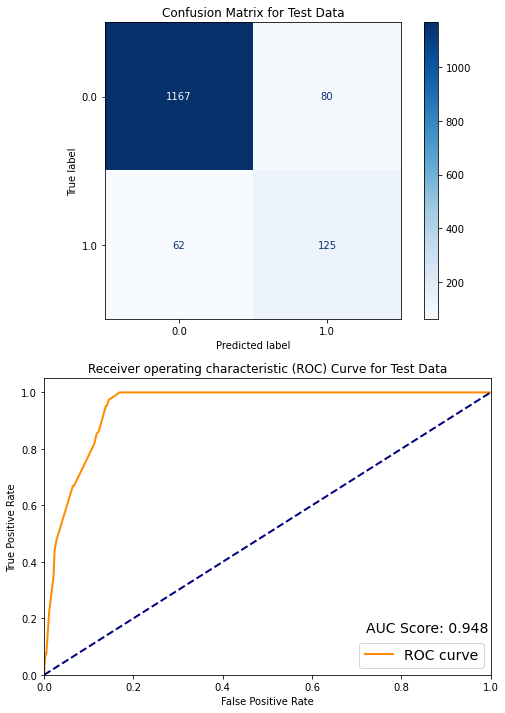

In [17]:
evaluate(dt_gs, X_train, y_train, X_test, y_test, grid_search=True)

In [18]:
dt_gs.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numerical',
                                                                         Pipeline(steps=[('min_max',
                                                                                          MinMaxScaler())]),
                                                                         ['BodyMass-Value']),
                                                                        ('proportional',
                                                                         Pipeline(steps=[('div100',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x7febcfc91dc0>))]),
                                                                         ['ForStrat-watbelowsurf',
                         

In [19]:
pd.DataFrame(dt_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__criterion,param_dt__max_depth,param_dt__min_samples_split,params,split0_test_recall,split1_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.028209,0.001556,0.009451,0.001160,gini,3,2,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
1,0.027131,0.001816,0.008173,0.000409,gini,3,5,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
2,0.025826,0.000719,0.007715,0.000232,gini,3,10,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
3,0.030521,0.000518,0.007638,0.000412,gini,5,2,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.670213,0.659574,...,0.024945,5,0.639594,0.626263,0.602597,0.625337,0.670185,0.632795,0.022156,11
4,0.032477,0.000626,0.008588,0.000402,gini,5,5,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.670213,0.654255,...,0.023447,4,0.639594,0.624365,0.607792,0.625337,0.670185,0.633455,0.020947,7
5,0.032614,0.000706,0.007938,0.000347,gini,5,10,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.659574,0.654255,...,0.021944,6,0.634271,0.624365,0.607792,0.625337,0.670185,0.632390,0.020742,12
6,0.043716,0.003406,0.008367,0.000418,gini,50,2,"{'dt__criterion': 'gini', 'dt__max_depth': 50,...",0.579787,0.585106,...,0.031018,13,0.578249,0.575916,0.609819,0.613402,0.576177,0.590713,0.017120,13
7,0.044775,0.003487,0.008989,0.000586,gini,50,5,"{'dt__criterion': 'gini', 'dt__max_depth': 50,...",0.558511,0.526596,...,0.028782,16,0.551181,0.532258,0.579946,0.608466,0.574586,0.569287,0.025983,18
8,0.040676,0.003730,0.008433,0.001057,gini,50,10,"{'dt__criterion': 'gini', 'dt__max_depth': 50,...",0.579787,0.537234,...,0.022213,17,0.576720,0.550409,0.604396,0.587601,0.567416,0.577308,0.018229,17
9,0.024687,0.001098,0.007992,0.001275,entropy,3,2,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.654255,0.585106,...,0.034328,10,0.654255,0.609418,0.593838,0.637602,0.670360,0.633095,0.028137,8


AUC Score: 0.7994738173756052


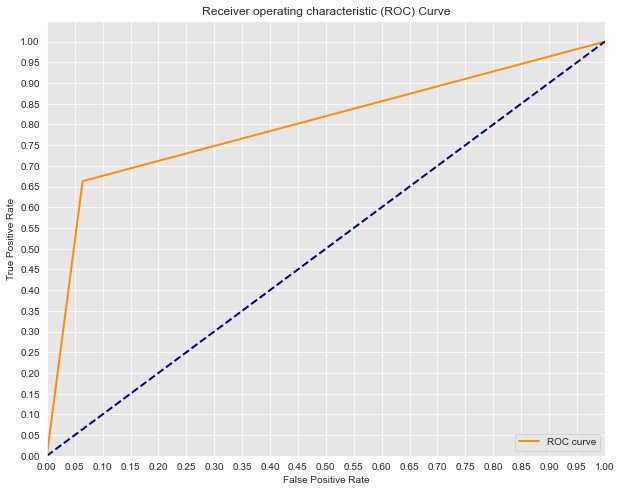

In [20]:
y_score = dt_gs.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [21]:
# Okay scores
print("Train score:",dt_gs.score(X_train,y_train))
print("Test score: ",dt_gs.score(X_test,y_test))

Train score: 0.687299893276414
Test score:  0.6631016042780749


# Logistic Regression Modeling

In [22]:
log_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                   ('log', LogisticRegression())])

log_grid = {'log__class_weight': [None,'balanced'],
          'log__penalty': ['l1', 'l2'],
          'log__C': [.1,.25,.5,1.0],
           'log__max_iter': [100,1000,10000]}

scoring_metrics = ['recall', 'f1']

log_gs = GridSearchCV(estimator=log_pipe, param_grid=log_grid, scoring=scoring_metrics, refit='recall')

In [23]:
log1 = log_gs.fit(X_train,y_train)

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

In [24]:
pd.DataFrame(log1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__class_weight,param_log__max_iter,param_log__penalty,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.015527,0.002412,0.000000,0.000000,0.1,None,100,l1,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",NaN,...,NaN,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48
1,0.040821,0.000993,0.008893,0.000257,0.1,None,100,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.574468,...,0.023411,22,0.611898,0.631579,0.655172,0.615385,0.608187,0.624444,0.017314,22
2,0.013894,0.001153,0.000000,0.000000,0.1,None,1000,l1,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",NaN,...,NaN,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29
3,0.040117,0.001276,0.008259,0.000632,0.1,None,1000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.574468,...,0.023411,22,0.611898,0.631579,0.655172,0.615385,0.608187,0.624444,0.017314,22
4,0.021186,0.003418,0.000000,0.000000,0.1,None,10000,l1,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",NaN,...,NaN,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40
5,0.036537,0.002448,0.007554,0.000450,0.1,None,10000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.574468,...,0.023411,22,0.611898,0.631579,0.655172,0.615385,0.608187,0.624444,0.017314,22
6,0.012720,0.001602,0.000000,0.000000,0.1,balanced,100,l1,"{'log__C': 0.1, 'log__class_weight': 'balanced...",NaN,...,NaN,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26
7,0.042354,0.001688,0.008428,0.001777,0.1,balanced,100,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10
8,0.012320,0.000888,0.000000,0.000000,0.1,balanced,1000,l1,"{'log__C': 0.1, 'log__class_weight': 'balanced...",NaN,...,NaN,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46
9,0.048734,0.004338,0.008014,0.000434,0.1,balanced,1000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10


In [25]:
log1.best_params_

{'log__C': 0.1,
 'log__class_weight': 'balanced',
 'log__max_iter': 100,
 'log__penalty': 'l2'}

AUC Score: 0.9016205738692649


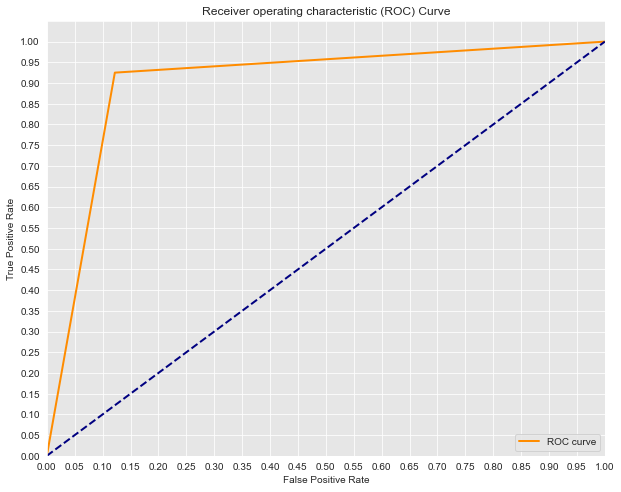

In [26]:
y_score = log1.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [27]:
# Good baseline score
print("Train score:",log1.score(X_train,y_train))
print("Test score: ",log1.score(X_test,y_test))

Train score: 0.9327641408751334
Test score:  0.9251336898395722


In [28]:
log_pipe_2 = Pipeline(steps=[('preprocessor', preprocessor),
                   ('log', LogisticRegression())])

log_grid_2 = {'log__class_weight': [None,'balanced'],
              'log__penalty': ['l2'],
              'log__C': [.1,.25,.5,1.0],
              'log__max_iter': [100,1000,10000]}

scoring_metrics = ['recall', 'f1']

log_gs_2 = GridSearchCV(estimator=log_pipe_2, param_grid=log_grid_2, scoring=scoring_metrics, refit='recall')

In [29]:
log2 = log_gs_2.fit(X_train,y_train)

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

In [30]:
pd.DataFrame(log2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__class_weight,param_log__max_iter,param_log__penalty,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.048958,0.003301,0.009500,0.001579,0.1,None,100,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.574468,...,0.023411,22,0.611898,0.631579,0.655172,0.615385,0.608187,0.624444,0.017314,22
1,0.071782,0.005663,0.013711,0.001825,0.1,None,1000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.574468,...,0.023411,22,0.611898,0.631579,0.655172,0.615385,0.608187,0.624444,0.017314,22
2,0.085441,0.023208,0.014759,0.002873,0.1,None,10000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.574468,...,0.023411,22,0.611898,0.631579,0.655172,0.615385,0.608187,0.624444,0.017314,22
3,0.091850,0.022903,0.012181,0.002053,0.1,balanced,100,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10
4,0.058853,0.002665,0.009305,0.000725,0.1,balanced,1000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10
5,0.055198,0.001744,0.009045,0.000780,0.1,balanced,10000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10
6,0.059032,0.001751,0.009038,0.000455,0.25,None,100,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.595745,...,0.023319,19,0.620499,0.635870,0.657143,0.619883,0.612717,0.629222,0.015871,19
7,0.062370,0.001724,0.009949,0.000970,0.25,None,1000,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.595745,...,0.023319,19,0.620499,0.635870,0.657143,0.619883,0.612717,0.629222,0.015871,19
8,0.058400,0.002254,0.008479,0.000360,0.25,None,10000,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.595745,...,0.023319,19,0.620499,0.635870,0.657143,0.619883,0.612717,0.629222,0.015871,19
9,0.091012,0.041780,0.010883,0.002852,0.25,balanced,100,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.920213,...,0.010997,4,0.683794,0.683594,0.707317,0.702479,0.676000,0.690637,0.012076,4


In [31]:
log2.best_params_

{'log__C': 0.1,
 'log__class_weight': 'balanced',
 'log__max_iter': 100,
 'log__penalty': 'l2'}

AUC Score: 0.9016205738692649


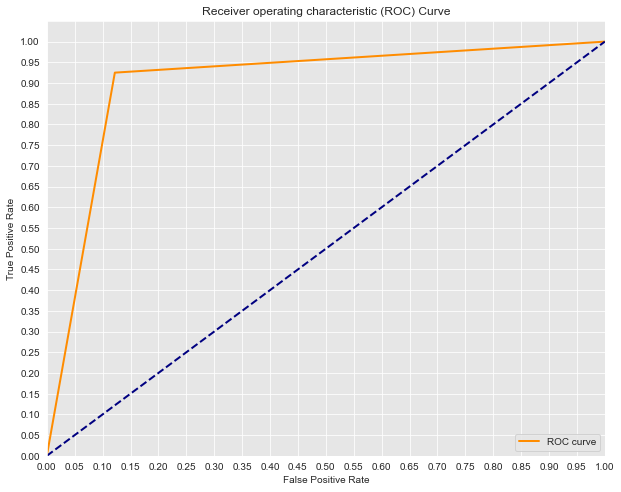

In [32]:
y_score = log2.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [33]:
# Same as above
print("Train score:",log2.score(X_train,y_train))
print("Test score: ",log2.score(X_test,y_test))

Train score: 0.9327641408751334
Test score:  0.9251336898395722


In [34]:
data_train = [X_train['agriculture_threat'], X_train['biological_threat'], X_train['climate_change_threat'],
              X_train['energy_mining_threat'], X_train['geological_threat'], X_train['human_intrusions_threat'],
              X_train['natural_systems_threat'], X_train['pollution_threat'], X_train['res_comm_dev_threat'], 
              X_train['transportation_threat'], X_train['invasive_threat']]

threats_train = pd.concat(data_train, axis=1)

In [35]:
data_test = [X_test['agriculture_threat'], X_test['biological_threat'], X_test['climate_change_threat'],
              X_test['energy_mining_threat'], X_test['geological_threat'], X_test['human_intrusions_threat'],
              X_test['natural_systems_threat'], X_test['pollution_threat'], X_test['res_comm_dev_threat'], 
              X_test['transportation_threat'], X_test['invasive_threat']]

threats_test = pd.concat(data_test, axis=1)

In [127]:
log_pipe_3 = Pipeline(steps=[('log', LogisticRegression())])

log_grid_3 = {'log__class_weight': [None,'balanced'],
              'log__penalty': ['l2'],
              'log__C': [.1,.25,.5,1.0],
              'log__max_iter': [100,1000,10000]}

scoring_metrics = ['recall', 'f1']

log_gs_3 = GridSearchCV(estimator=log_pipe_3, param_grid=log_grid_3, scoring=scoring_metrics, refit='recall')

In [128]:
log3 = log_gs_3.fit(threats_train,y_train)

In [129]:
pd.DataFrame(log3.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__class_weight,param_log__max_iter,param_log__penalty,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.012725,0.002843,0.004350,0.000508,0.1,None,100,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.452128,...,0.022560,22,0.513595,0.533762,0.520000,0.485050,0.510769,0.512635,0.015912,22
1,0.009596,0.000753,0.003308,0.000321,0.1,None,1000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.452128,...,0.022560,22,0.513595,0.533762,0.520000,0.485050,0.510769,0.512635,0.015912,22
2,0.009202,0.000124,0.003199,0.000110,0.1,None,10000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.452128,...,0.022560,22,0.513595,0.533762,0.520000,0.485050,0.510769,0.512635,0.015912,22
3,0.009680,0.000599,0.003156,0.000043,0.1,balanced,100,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
4,0.009797,0.000245,0.003192,0.000031,0.1,balanced,1000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
5,0.009856,0.000351,0.003252,0.000090,0.1,balanced,10000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
6,0.009742,0.000614,0.003191,0.000126,0.25,None,100,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.489362,...,0.028146,19,0.542773,0.536741,0.505051,0.533333,0.501529,0.523885,0.017122,19
7,0.011378,0.000818,0.003800,0.000487,0.25,None,1000,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.489362,...,0.028146,19,0.542773,0.536741,0.505051,0.533333,0.501529,0.523885,0.017122,19
8,0.012873,0.002372,0.004381,0.001305,0.25,None,10000,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.489362,...,0.028146,19,0.542773,0.536741,0.505051,0.533333,0.501529,0.523885,0.017122,19
9,0.012788,0.001150,0.003546,0.000288,0.25,balanced,100,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.692153,0.664078,0.669420,0.015833,7


In [130]:
log3.best_params_

{'log__C': 1.0,
 'log__class_weight': 'balanced',
 'log__max_iter': 100,
 'log__penalty': 'l2'}

AUC Score: 0.8663273138955954


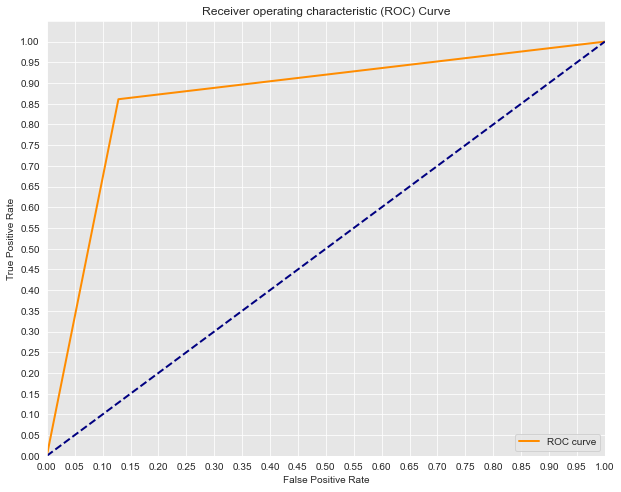

In [131]:
y_score = log3.predict(threats_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [132]:
# Not as good as above, but still pretty good. Slightly overfit.
print("Train score:",log3.score(threats_train,y_train))
print("Test score: ",log3.score(threats_test,y_test))

Train score: 0.9092849519743863
Test score:  0.8609625668449198


In [42]:
log_pipe_4 = Pipeline(steps=[('log', LogisticRegression())])

log_grid_4 = {'log__class_weight': [None,'balanced'],
              'log__penalty': ['l2'],
              'log__C': [.1,.25,.5,1.0],
              'log__max_iter': [100,1000,10000]}

scoring_metrics = ['recall', 'f1']

log_gs_4 = GridSearchCV(estimator=log_pipe_4, param_grid=log_grid_4, scoring=scoring_metrics, refit='recall')

In [43]:
log4 = log_gs_4.fit(threats_train,y_train)

In [44]:
pd.DataFrame(log4.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__class_weight,param_log__max_iter,param_log__penalty,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.012221,0.001897,0.004084,0.000202,0.1,None,100,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.452128,...,0.022560,22,0.513595,0.533762,0.520000,0.485050,0.510769,0.512635,0.015912,22
1,0.011013,0.000533,0.004281,0.000236,0.1,None,1000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.452128,...,0.022560,22,0.513595,0.533762,0.520000,0.485050,0.510769,0.512635,0.015912,22
2,0.011384,0.000403,0.003660,0.000227,0.1,None,10000,l2,"{'log__C': 0.1, 'log__class_weight': None, 'lo...",0.452128,...,0.022560,22,0.513595,0.533762,0.520000,0.485050,0.510769,0.512635,0.015912,22
3,0.012750,0.002159,0.004312,0.000560,0.1,balanced,100,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
4,0.011445,0.000336,0.003702,0.000190,0.1,balanced,1000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
5,0.011893,0.000525,0.003739,0.000191,0.1,balanced,10000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1
6,0.012987,0.001332,0.003749,0.000260,0.25,None,100,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.489362,...,0.028146,19,0.542773,0.536741,0.505051,0.533333,0.501529,0.523885,0.017122,19
7,0.012079,0.000509,0.003505,0.000057,0.25,None,1000,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.489362,...,0.028146,19,0.542773,0.536741,0.505051,0.533333,0.501529,0.523885,0.017122,19
8,0.012554,0.001123,0.004084,0.000456,0.25,None,10000,l2,"{'log__C': 0.25, 'log__class_weight': None, 'l...",0.489362,...,0.028146,19,0.542773,0.536741,0.505051,0.533333,0.501529,0.523885,0.017122,19
9,0.012308,0.000607,0.003606,0.000167,0.25,balanced,100,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.692153,0.664078,0.669420,0.015833,7


In [45]:
# This configuration seems to keep coming up as the best performing set of parameters
log4.best_params_

{'log__C': 1.0,
 'log__class_weight': 'balanced',
 'log__max_iter': 100,
 'log__penalty': 'l2'}

AUC Score: 0.8663273138955954


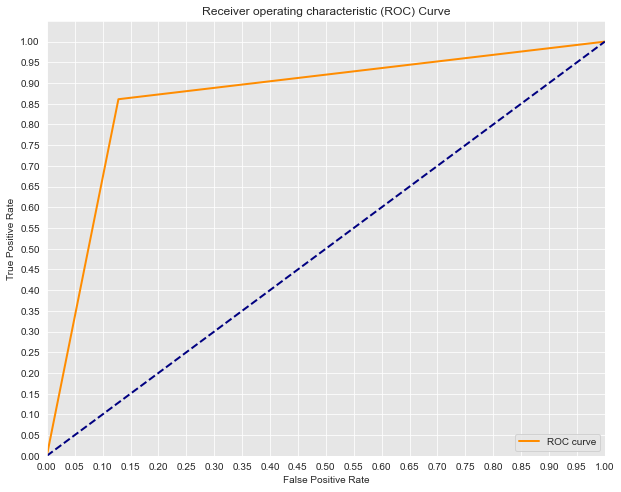

In [46]:
y_score = log4.predict(threats_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [47]:
# Not as good as above, but still pretty good. Slightly overfit.
print("Train score:",log4.score(threats_train,y_train))
print("Test score: ",log4.score(threats_test,y_test))

Train score: 0.9092849519743863
Test score:  0.8609625668449198


# Random Forest Modeling

In [48]:
for_pipe1 = Pipeline(steps=[('preprocessor', preprocessor),
                   ('for', RandomForestClassifier())])

for_grid1 = {'for__n_estimators': [10,100,1000],
          'for__max_depth': [2,5,10],
          'for__criterion': ['gini', 'entropy']}

scoring_metrics = ['recall', 'f1']

for_gs1 = GridSearchCV(estimator=for_pipe1, param_grid=for_grid1, scoring=scoring_metrics, refit='recall')

In [49]:
for1 = for_gs1.fit(X_train,y_train)

In [50]:
pd.DataFrame(for1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_for__criterion,param_for__max_depth,param_for__n_estimators,params,split0_test_recall,split1_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.039635,0.001615,0.010444,0.000455,gini,2,10,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.005319,0.010638,...,0.011918,13,0.010582,0.021053,0.072165,0.010417,0.031250,0.029093,0.022873,13
1,0.213407,0.005869,0.021199,0.000658,gini,2,100,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.005319,0.000000,...,0.002128,18,0.010582,0.000000,0.000000,0.000000,0.000000,0.002116,0.004233,18
2,2.086602,0.057282,0.142432,0.021060,gini,2,1000,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.000000,0.005319,...,0.002613,16,0.000000,0.010582,0.000000,0.000000,0.010638,0.004244,0.005198,16
3,0.045210,0.000859,0.010926,0.000728,gini,5,10,"{'for__criterion': 'gini', 'for__max_depth': 5...",0.281915,0.388298,...,0.074806,8,0.401515,0.498294,0.568690,0.401544,0.451128,0.464234,0.063414,10
4,0.294615,0.015087,0.022690,0.000476,gini,5,100,"{'for__criterion': 'gini', 'for__max_depth': 5...",0.356383,0.345745,...,0.028797,10,0.489051,0.476190,0.489510,0.418251,0.450382,0.464677,0.027214,9
5,2.915783,0.181424,0.152635,0.018826,gini,5,1000,"{'for__criterion': 'gini', 'for__max_depth': 5...",0.335106,0.335106,...,0.023002,11,0.475472,0.471910,0.461538,0.415385,0.423529,0.449567,0.025140,11
6,0.065433,0.006343,0.014331,0.002185,gini,10,10,"{'for__criterion': 'gini', 'for__max_depth': 1...",0.553191,0.515957,...,0.030560,5,0.601156,0.577381,0.616766,0.574018,0.628895,0.599643,0.021464,5
7,0.474141,0.026383,0.030845,0.006293,gini,10,100,"{'for__criterion': 'gini', 'for__max_depth': 1...",0.579787,0.595745,...,0.023970,3,0.639296,0.638177,0.680115,0.616279,0.629080,0.640589,0.021416,3
8,4.035679,0.151516,0.209636,0.028796,gini,10,1000,"{'for__criterion': 'gini', 'for__max_depth': 1...",0.590426,0.606383,...,0.016318,2,0.645349,0.649573,0.658892,0.615836,0.646884,0.643307,0.014517,2
9,0.044814,0.004378,0.013212,0.004670,entropy,2,10,"{'for__criterion': 'entropy', 'for__max_depth'...",0.005319,0.026596,...,0.009286,14,0.010582,0.051813,0.031250,0.000000,0.031414,0.025012,0.018067,14


In [51]:
for1.best_params_

{'for__criterion': 'entropy', 'for__max_depth': 10, 'for__n_estimators': 1000}

AUC Score: 0.7616354116189014


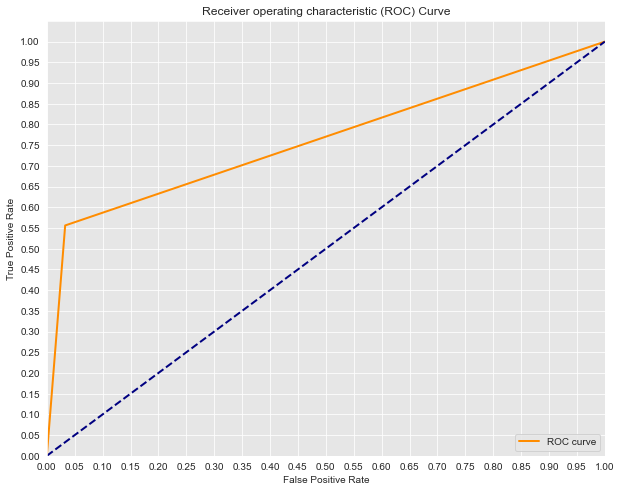

In [52]:
y_score = for1.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [53]:
# Overfitting
print("Train score:",for1.score(X_train,y_train))
print("Test score: ",for1.score(X_test,y_test))

Train score: 0.8249733191035219
Test score:  0.5561497326203209


In [54]:
for_pipe2 = Pipeline(steps=[('preprocessor', preprocessor),
                   ('for', RandomForestClassifier())])

for_grid2 = {'for__n_estimators': [10,100,1000],
             'for__max_depth': [2,5,10,50,100],
             'for__min_samples_split': [2,5,10],
             'for__criterion': ['gini', 'entropy']}

scoring_metrics = ['recall', 'f1']

for_gs2 = GridSearchCV(estimator=for_pipe2, param_grid=for_grid2, scoring=scoring_metrics, refit='recall')

In [55]:
for2 = for_gs2.fit(X_train,y_train)

In [56]:
pd.DataFrame(for2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_for__criterion,param_for__max_depth,param_for__min_samples_split,param_for__n_estimators,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.036927,0.001591,0.010153,0.000364,gini,2,2,10,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.047872,...,0.018103,76,0.090452,0.071429,0.020942,0.021164,0.000000,0.040797,0.034199,76
1,0.216224,0.004984,0.020898,0.000614,gini,2,2,100,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.000000,...,0.002613,83,0.000000,0.010582,0.000000,0.000000,0.010638,0.004244,0.005198,83
2,1.874764,0.052359,0.121807,0.013933,gini,2,2,1000,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.010638,...,0.003982,79,0.021053,0.010582,0.000000,0.000000,0.010638,0.008455,0.007886,79
3,0.033620,0.001607,0.009972,0.001123,gini,2,5,10,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.101064,...,0.032524,73,0.179245,0.041451,0.020833,0.071429,0.117073,0.086006,0.056752,73
4,0.198072,0.005864,0.019901,0.001741,gini,2,5,100,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.000000,...,0.002620,82,0.000000,0.000000,0.010582,0.010638,0.010638,0.006372,0.005203,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.445104,0.016685,0.028590,0.001961,entropy,100,5,100,"{'for__criterion': 'entropy', 'for__max_depth'...",0.611702,...,0.022849,23,0.649718,0.652174,0.679558,0.636103,0.651429,0.653796,0.014153,23
86,4.208209,0.040241,0.189498,0.008948,entropy,100,5,1000,"{'for__criterion': 'entropy', 'for__max_depth'...",0.643617,...,0.013693,5,0.666667,0.655827,0.681440,0.653521,0.689076,0.669306,0.013971,5
87,0.061418,0.001596,0.010752,0.000263,entropy,100,10,10,"{'for__criterion': 'entropy', 'for__max_depth'...",0.611702,...,0.020782,28,0.614973,0.587258,0.653631,0.637931,0.623596,0.623478,0.022371,41
88,0.422776,0.022807,0.027139,0.002565,entropy,100,10,100,"{'for__criterion': 'entropy', 'for__max_depth'...",0.659574,...,0.025112,20,0.670270,0.629526,0.668539,0.637931,0.670391,0.655332,0.017850,22


In [57]:
for2.best_params_

{'for__criterion': 'gini',
 'for__max_depth': 100,
 'for__min_samples_split': 5,
 'for__n_estimators': 1000}

AUC Score: 0.7812889973369241


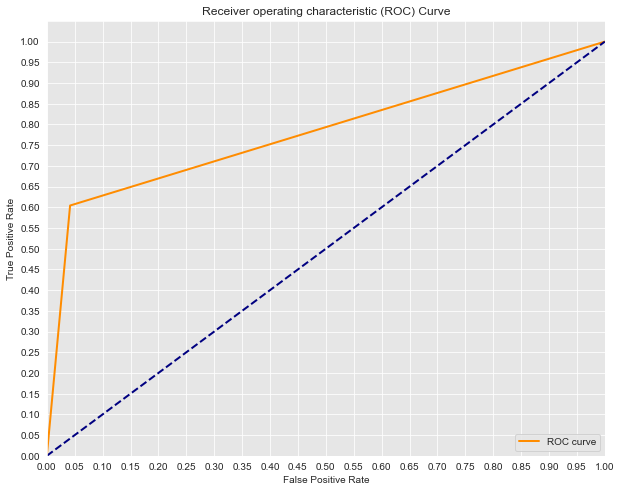

In [58]:
y_score = for2.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [59]:
# Massive overfitting
print("Train score:",for2.score(X_train,y_train))
print("Test score: ",for2.score(X_test,y_test))

Train score: 0.9903948772678762
Test score:  0.6042780748663101


# Bagged Tree Modeling

In [60]:
bag_pipe1 = Pipeline(steps=[('preprocessor', preprocessor),
                   ('bag', BaggingClassifier())])

bag_grid1 = {'bag__base_estimator': [DecisionTreeClassifier()],
             'bag__n_estimators': [5,10,15,20],
             'bag__bootstrap': [True,False],
             'bag__bootstrap_features': [True,False]}

scoring_metrics = ['recall', 'f1']

bag_gs1 = GridSearchCV(estimator=bag_pipe1, param_grid=bag_grid1, scoring=scoring_metrics, refit='recall')

In [61]:
bag1 = bag_gs1.fit(X_train,y_train)

In [62]:
pd.DataFrame(bag1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bag__base_estimator,param_bag__bootstrap,param_bag__bootstrap_features,param_bag__n_estimators,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.125760,0.010014,0.011160,0.000982,DecisionTreeClassifier(),True,True,5,{'bag__base_estimator': DecisionTreeClassifier...,0.558511,...,0.030816,11,0.580110,0.546448,0.583333,0.568966,0.621622,0.580096,0.024458,9
1,0.234916,0.009467,0.013348,0.000554,DecisionTreeClassifier(),True,True,10,{'bag__base_estimator': DecisionTreeClassifier...,0.563830,...,0.041617,15,0.603989,0.569733,0.594937,0.595611,0.511041,0.575062,0.034003,10
2,0.371395,0.019744,0.017156,0.000938,DecisionTreeClassifier(),True,True,15,{'bag__base_estimator': DecisionTreeClassifier...,0.569149,...,0.030121,7,0.616715,0.625000,0.618497,0.617564,0.568915,0.609338,0.020422,4
3,0.453446,0.023868,0.019258,0.001235,DecisionTreeClassifier(),True,True,20,{'bag__base_estimator': DecisionTreeClassifier...,0.553191,...,0.036543,14,0.611765,0.593472,0.581602,0.599407,0.525000,0.582249,0.030230,8
4,0.108149,0.005279,0.011164,0.000539,DecisionTreeClassifier(),True,False,5,{'bag__base_estimator': DecisionTreeClassifier...,0.643617,...,0.009526,2,0.641910,0.617021,0.604167,0.615385,0.639344,0.623565,0.014639,3
5,0.185205,0.010396,0.012023,0.000688,DecisionTreeClassifier(),True,False,10,{'bag__base_estimator': DecisionTreeClassifier...,0.590426,...,0.019016,9,0.621849,0.603261,0.574648,0.590529,0.593660,0.596789,0.015550,7
6,0.263566,0.012357,0.013950,0.001511,DecisionTreeClassifier(),True,False,15,{'bag__base_estimator': DecisionTreeClassifier...,0.654255,...,0.019929,1,0.643979,0.627249,0.668394,0.634409,0.645161,0.643838,0.013920,1
7,0.339809,0.013815,0.014457,0.000351,DecisionTreeClassifier(),True,False,20,{'bag__base_estimator': DecisionTreeClassifier...,0.606383,...,0.017328,3,0.633333,0.623955,0.654054,0.623306,0.657061,0.638342,0.014528,2
8,0.184562,0.013569,0.010185,0.000246,DecisionTreeClassifier(),False,True,5,{'bag__base_estimator': DecisionTreeClassifier...,0.590426,...,0.030054,13,0.609890,0.546479,0.609971,0.536723,0.568966,0.574406,0.030833,12
9,0.330295,0.022035,0.012985,0.000495,DecisionTreeClassifier(),False,True,10,{'bag__base_estimator': DecisionTreeClassifier...,0.494681,...,0.029850,16,0.577640,0.535385,0.613982,0.579882,0.555205,0.572419,0.026375,15


In [63]:
bag1.best_params_

{'bag__base_estimator': DecisionTreeClassifier(),
 'bag__bootstrap': True,
 'bag__bootstrap_features': False,
 'bag__n_estimators': 15}

AUC Score: 0.7705959543546221


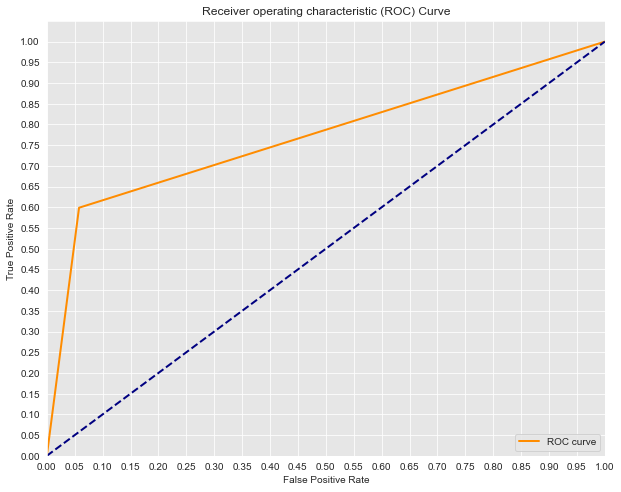

In [64]:
y_score = bag1.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [65]:
# Massive overfitting
print("Train score:",bag1.score(X_train,y_train))
print("Test score: ",bag1.score(X_test,y_test))

Train score: 0.9957310565635006
Test score:  0.5989304812834224


In [66]:
bag_pipe2 = Pipeline(steps=[('preprocessor', preprocessor),
                   ('bag', BaggingClassifier())])

bag_grid2 = {'bag__base_estimator': [DecisionTreeClassifier()],
             'bag__n_estimators': [5,10,15,20],
             'bag__bootstrap': [True,False],
             'bag__bootstrap_features': [True,False],
             'bag__max_samples': [1,5,10],
             'bag__max_features': [1,5,10]}

scoring_metrics = ['recall', 'f1']

bag_gs2 = GridSearchCV(estimator=bag_pipe2, param_grid=bag_grid2, scoring=scoring_metrics, refit='recall')

In [67]:
bag2 = bag_gs2.fit(X_train,y_train)

In [68]:
pd.DataFrame(bag2.cv_results_).sort_values(by='rank_test_recall', ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bag__base_estimator,param_bag__bootstrap,param_bag__bootstrap_features,param_bag__max_features,param_bag__max_samples,param_bag__n_estimators,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
84,0.022455,0.000827,0.007876,0.000053,DecisionTreeClassifier(),False,True,5,1,5,...,0.400000,1,0.231813,0.000000,0.000000,0.000000,0.000000,0.046363,0.092725,12
88,0.023881,0.000526,0.009044,0.000318,DecisionTreeClassifier(),False,True,5,5,5,...,0.188324,2,0.098522,0.000000,0.501393,0.000000,0.000000,0.119983,0.194485,2
32,0.025705,0.001431,0.009120,0.000501,DecisionTreeClassifier(),True,True,10,10,5,...,0.072342,3,0.000000,0.296578,0.126829,0.146119,0.040404,0.121986,0.102591,1
92,0.022011,0.000347,0.007924,0.000205,DecisionTreeClassifier(),False,True,5,10,5,...,0.062014,4,0.151786,0.000000,0.080808,0.052083,0.254826,0.107901,0.088323,3
64,0.025411,0.000550,0.009212,0.000304,DecisionTreeClassifier(),True,False,10,5,5,...,0.078884,5,0.000000,0.000000,0.116505,0.000000,0.271429,0.077587,0.106910,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42,0.040813,0.003250,0.011443,0.001678,DecisionTreeClassifier(),True,False,1,5,15,...,0.000000,36,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36
41,0.031337,0.000879,0.010121,0.000372,DecisionTreeClassifier(),True,False,1,5,10,...,0.000000,36,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36
40,0.024375,0.000232,0.009709,0.000233,DecisionTreeClassifier(),True,False,1,5,5,...,0.000000,36,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36
55,0.049868,0.000395,0.011602,0.000475,DecisionTreeClassifier(),True,False,5,5,20,...,0.000000,36,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,36


In [69]:
bag2.best_params_

{'bag__base_estimator': DecisionTreeClassifier(),
 'bag__bootstrap': False,
 'bag__bootstrap_features': True,
 'bag__max_features': 5,
 'bag__max_samples': 1,
 'bag__n_estimators': 5}

AUC Score: 0.5


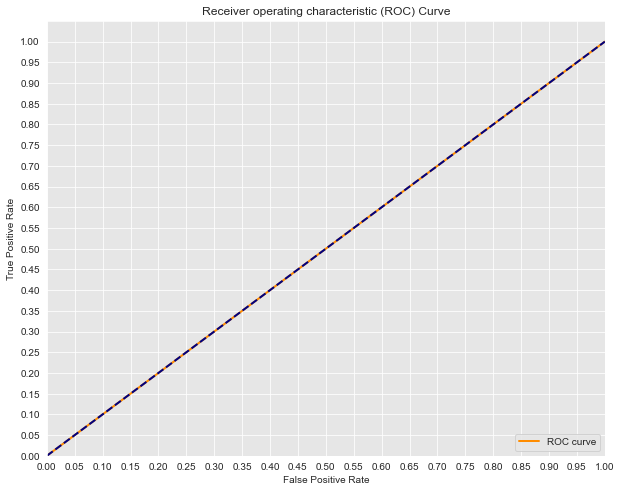

In [70]:
y_score = bag2.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [71]:
# 0 doesn't seem good
print("Train score:",bag2.score(X_train,y_train))
print("Test score: ",bag2.score(X_test,y_test))

Train score: 0.0
Test score:  0.0


# Naive Bayes Modeling

In [75]:
gnb_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                   ('gnb', GaussianNB())])

gnb_grid = {'gnb__priors': [None]}

scoring_metrics = ['recall', 'f1']

gnb_gs = GridSearchCV(estimator=gnb_pipe, param_grid=gnb_grid, scoring=scoring_metrics, refit='recall')

In [76]:
gnb_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numerical',
                                                                         Pipeline(steps=[('min_max',
                                                                                          MinMaxScaler())]),
                                                                         ['BodyMass-Value']),
                                                                        ('proportional',
                                                                         Pipeline(steps=[('div100',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x7febcfc91dc0>))]),
                                                                         ['ForStrat-watbelowsurf',
                         

In [77]:
pd.DataFrame(gnb_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gnb__priors,params,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.027292,0.004596,0.010873,0.002336,None,{'gnb__priors': None},0.840426,0.81383,0.705882,0.775401,...,0.069116,1,0.598485,0.616935,0.631579,0.614407,0.589655,0.610212,0.014693,1


AUC Score: 0.803892979514471


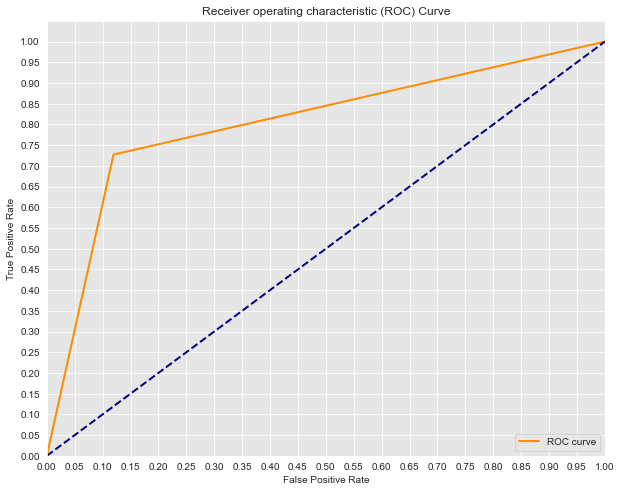

In [78]:
y_score = gnb_gs.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [79]:
# Some overfitting, but not too bad.
print("Train score:",gnb_gs.score(X_train,y_train))
print("Test score: ",gnb_gs.score(X_test,y_test))

Train score: 0.823906083244397
Test score:  0.7272727272727273


In [133]:
mnb_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                   ('mnb', MultinomialNB())])

mnb_grid = {'mnb__alpha': [1.0],
           'mnb__fit_prior': [True,False]}

scoring_metrics = ['recall', 'f1']

mnb_gs = GridSearchCV(estimator=mnb_pipe, param_grid=mnb_grid, scoring=scoring_metrics, refit='recall')

In [134]:
mnb_gs.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numerical',
                                                                         Pipeline(steps=[('min_max',
                                                                                          MinMaxScaler())]),
                                                                         ['BodyMass-Value']),
                                                                        ('proportional',
                                                                         Pipeline(steps=[('div100',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x7febcfc91dc0>))]),
                                                                         ['ForStrat-watbelowsurf',
                         

In [135]:
pd.DataFrame(mnb_gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mnb__alpha,param_mnb__fit_prior,params,split0_test_recall,split1_test_recall,split2_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.034751,0.012409,0.012274,0.002709,1,True,"{'mnb__alpha': 1.0, 'mnb__fit_prior': True}",0.813830,0.760638,0.807487,...,0.020594,2,0.660907,0.655963,0.691076,0.665127,0.656250,0.665865,0.013048,2
1,0.017491,0.000863,0.008492,0.000574,1,False,"{'mnb__alpha': 1.0, 'mnb__fit_prior': False}",0.962766,0.941489,0.957219,...,0.011196,1,0.656987,0.657993,0.675472,0.674374,0.671642,0.667293,0.008107,1


In [136]:
mnb_gs.best_params_

{'mnb__alpha': 1.0, 'mnb__fit_prior': False}

AUC Score: 0.8930674259935075


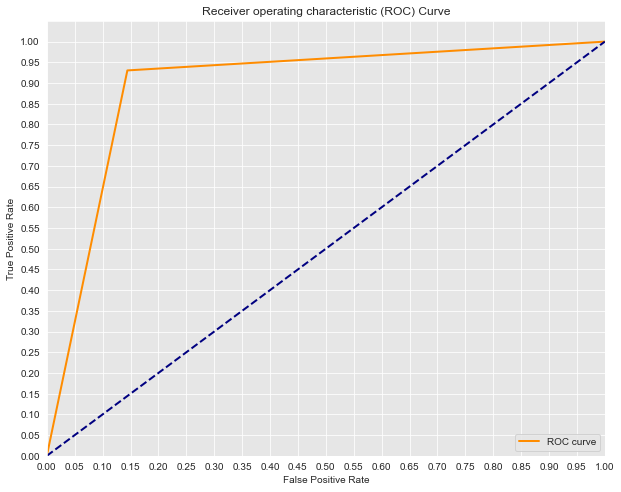

In [137]:
y_score = mnb_gs.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [87]:
# Really good overall.
print("Train score:",mnb_gs.score(X_train,y_train))
print("Test score: ",mnb_gs.score(X_test,y_test))

Train score: 0.951974386339381
Test score:  0.93048128342246


# XGBoost Modeling

In [89]:
xgb_pipe1 = Pipeline(steps=[('preprocessor', preprocessor),
                   ('xgb', XGBClassifier())])

xgb_grid1 = {'xgb__n_estimators': [10,50,100],
           'xgb__max_depth': [3,5,10],
           'xgb__learning_rate': [0.1,0.2],
           'xgb__min_child_weight': [1,2],
           'xgb__subsample': [0.5,0.7]}

scoring_metrics = ['recall', 'f1']

xgb_gs1 = GridSearchCV(estimator=xgb_pipe1, param_grid=xgb_grid1, scoring=scoring_metrics, refit='recall')

In [90]:
xgb_gs1.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numerical',
                                                                         Pipeline(steps=[('min_max',
                                                                                          MinMaxScaler())]),
                                                                         ['BodyMass-Value']),
                                                                        ('proportional',
                                                                         Pipeline(steps=[('div100',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x7febcfc91dc0>))]),
                                                                         ['ForStrat-watbelowsurf',
                         

In [91]:
pd.DataFrame(xgb_gs1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_weight,param_xgb__n_estimators,param_xgb__subsample,params,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.068593,0.013012,0.012018,0.001218,0.1,3,1,10,0.5,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.023950,1,0.670241,0.681818,0.644330,0.670130,0.692308,0.671765,0.016005,7
1,0.062277,0.004305,0.011591,0.000566,0.1,3,1,10,0.7,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.018797,8,0.659740,0.652520,0.630208,0.666667,0.693122,0.660451,0.020416,40
2,0.168976,0.005847,0.012114,0.000697,0.1,3,1,50,0.5,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.030093,61,0.671916,0.670241,0.639769,0.657459,0.657382,0.659353,0.011553,46
3,0.167426,0.003166,0.012008,0.000244,0.1,3,1,50,0.7,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.025950,47,0.673740,0.671916,0.649860,0.655827,0.649860,0.660241,0.010522,41
4,0.295525,0.003170,0.013178,0.000719,0.1,3,1,100,0.5,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.033892,41,0.671835,0.668449,0.645714,0.648045,0.693989,0.665606,0.017644,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,0.101391,0.003776,0.013172,0.000151,0.2,10,2,10,0.7,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.037604,12,0.692708,0.651042,0.691489,0.661376,0.627451,0.664813,0.024848,26
68,0.383265,0.008094,0.013883,0.000209,0.2,10,2,50,0.5,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.013687,57,0.648936,0.638961,0.648045,0.670300,0.657459,0.652740,0.010554,62
69,0.427171,0.005785,0.014392,0.000417,0.2,10,2,50,0.7,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.014319,54,0.664908,0.650667,0.661202,0.642857,0.645161,0.652959,0.008704,61
70,0.786380,0.025932,0.014882,0.001142,0.2,10,2,100,0.5,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.012979,63,0.647368,0.625323,0.646240,0.648199,0.655827,0.644591,0.010207,68


In [92]:
xgb_gs1.best_params_

{'xgb__learning_rate': 0.1,
 'xgb__max_depth': 3,
 'xgb__min_child_weight': 1,
 'xgb__n_estimators': 10,
 'xgb__subsample': 0.5}

AUC Score: 0.7895805548289155


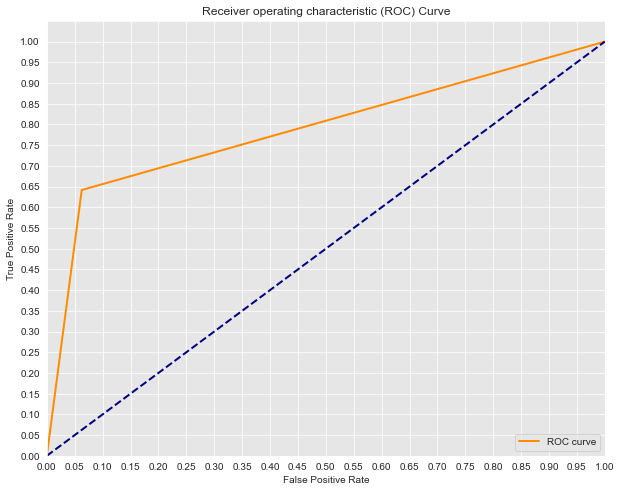

In [93]:
y_score = xgb_gs1.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [94]:
# Not as good as MNB but at least not overfit.
print("Train score:",xgb_gs1.score(X_train,y_train))
print("Test score: ",xgb_gs1.score(X_test,y_test))

Train score: 0.6819637139807898
Test score:  0.6417112299465241


In [96]:
xgb_pipe2 = Pipeline(steps=[('preprocessor', preprocessor),
                   ('xgb', XGBClassifier())])

xgb_grid2 = {'xgb__n_estimators': [1,3,5,10],
           'xgb__max_depth': [1,3,5],
           'xgb__learning_rate': [0.0,0.05,0.1],
           'xgb__min_child_weight': [0,1,2],
           'xgb__subsample': [0.3,0.5,0.7]}

scoring_metrics = ['recall', 'f1']

xgb_gs2 = GridSearchCV(estimator=xgb_pipe2, param_grid=xgb_grid2, scoring=scoring_metrics, refit='recall')

In [97]:
xgb_gs2.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numerical',
                                                                         Pipeline(steps=[('min_max',
                                                                                          MinMaxScaler())]),
                                                                         ['BodyMass-Value']),
                                                                        ('proportional',
                                                                         Pipeline(steps=[('div100',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x7febcfc91dc0>))]),
                                                                         ['ForStrat-watbelowsurf',
                         

In [98]:
pd.DataFrame(xgb_gs2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_weight,param_xgb__n_estimators,param_xgb__subsample,params,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.037820,0.005439,0.013706,0.002263,0,1,0,1,0.3,"{'xgb__learning_rate': 0.0, 'xgb__max_depth': ...",...,0.000000,217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,217
1,0.032512,0.000728,0.011493,0.000379,0,1,0,1,0.5,"{'xgb__learning_rate': 0.0, 'xgb__max_depth': ...",...,0.000000,217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,217
2,0.033460,0.000773,0.012257,0.000616,0,1,0,1,0.7,"{'xgb__learning_rate': 0.0, 'xgb__max_depth': ...",...,0.000000,217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,217
3,0.035316,0.001278,0.011872,0.000718,0,1,0,3,0.3,"{'xgb__learning_rate': 0.0, 'xgb__max_depth': ...",...,0.000000,217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,217
4,0.035671,0.001745,0.011924,0.000855,0,1,0,3,0.5,"{'xgb__learning_rate': 0.0, 'xgb__max_depth': ...",...,0.000000,217,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,0.054323,0.001770,0.012172,0.000167,0.1,5,2,5,0.5,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.033008,96,0.680739,0.652291,0.610644,0.655556,0.662983,0.652443,0.023102,40
320,0.056508,0.003597,0.012336,0.000290,0.1,5,2,5,0.7,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.026878,103,0.670213,0.636620,0.627027,0.664879,0.642659,0.648280,0.016588,52
321,0.066043,0.001892,0.012222,0.000166,0.1,5,2,10,0.3,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.025807,77,0.670241,0.632432,0.629834,0.645333,0.690217,0.653612,0.023234,38
322,0.075511,0.001568,0.012256,0.000259,0.1,5,2,10,0.5,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.017919,57,0.663130,0.664894,0.641096,0.682927,0.679245,0.666258,0.014774,9


In [99]:
xgb_gs2.best_params_

{'xgb__learning_rate': 0.05,
 'xgb__max_depth': 1,
 'xgb__min_child_weight': 0,
 'xgb__n_estimators': 1,
 'xgb__subsample': 0.5}

AUC Score: 0.8169939405375038


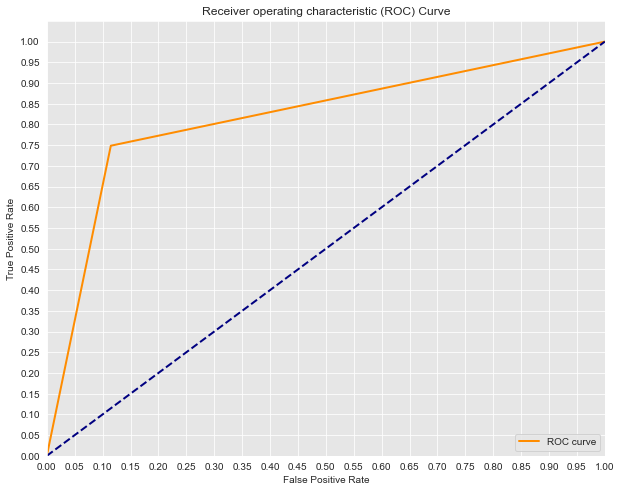

In [100]:
y_score = xgb_gs2.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

print("AUC Score:",auc(fpr, tpr))

# Seaborn's beautiful styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show();

In [101]:
# Better than the first one
print("Train score:",xgb_gs2.score(X_train,y_train))
print("Test score: ",xgb_gs2.score(X_test,y_test))

Train score: 0.7801494130202775
Test score:  0.7486631016042781


# Using Andrew's Evaluate Function on all above models

Training Metrics
Recall: 0.687
f1: 0.679
----
Testing Metrics
Recall: 0.663
f1: 0.634

Best Parameters for Recall
{'dt__criterion': 'entropy', 'dt__max_depth': 5, 'dt__min_samples_split': 2}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__criterion,param_dt__max_depth,param_dt__min_samples_split,params,split0_test_recall,split1_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
12,0.032823,0.001132,0.008408,0.000337,entropy,5,2,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.718085,0.664894,...,0.028719,1,0.671642,0.644330,0.625641,0.636119,0.675676,0.650681,0.019715,1
13,0.030346,0.000832,0.008025,0.000563,entropy,5,5,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.712766,0.664894,...,0.026844,2,0.668329,0.645995,0.625641,0.636119,0.675676,0.650352,0.018956,2
14,0.032945,0.001030,0.007963,0.000327,entropy,5,10,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.712766,0.664894,...,0.026844,2,0.666667,0.645995,0.625641,0.636119,0.675676,0.650019,0.018650,3
4,0.031525,0.000994,0.008144,0.000440,gini,5,5,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.675532,0.654255,...,0.024443,4,0.644670,0.624365,0.602597,0.629032,0.670185,0.634170,0.022480,7
3,0.030972,0.001171,0.008729,0.000305,gini,5,2,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.686170,0.654255,...,0.029253,5,0.649874,0.624365,0.604167,0.621622,0.670185,0.634043,0.023227,8
5,0.030025,0.001198,0.007889,0.000789,gini,5,10,"{'dt__criterion': 'gini', 'dt__max_depth': 5, ...",0.659574,0.654255,...,0.023343,6,0.634271,0.624365,0.606218,0.621622,0.670185,0.631332,0.021409,12
0,0.031222,0.003467,0.009295,0.001059,gini,3,2,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
1,0.024017,0.000756,0.007455,0.000267,gini,3,5,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
2,0.023885,0.000297,0.007361,0.000128,gini,3,10,"{'dt__criterion': 'gini', 'dt__max_depth': 3, ...",0.654255,0.664894,...,0.015633,7,0.654255,0.654450,0.625668,0.637602,0.670360,0.648467,0.015404,4
9,0.023887,0.000449,0.007409,0.000197,entropy,3,2,"{'dt__criterion': 'entropy', 'dt__max_depth': ...",0.654255,0.585106,...,0.034328,10,0.654255,0.609418,0.593838,0.637602,0.670360,0.633095,0.028137,9


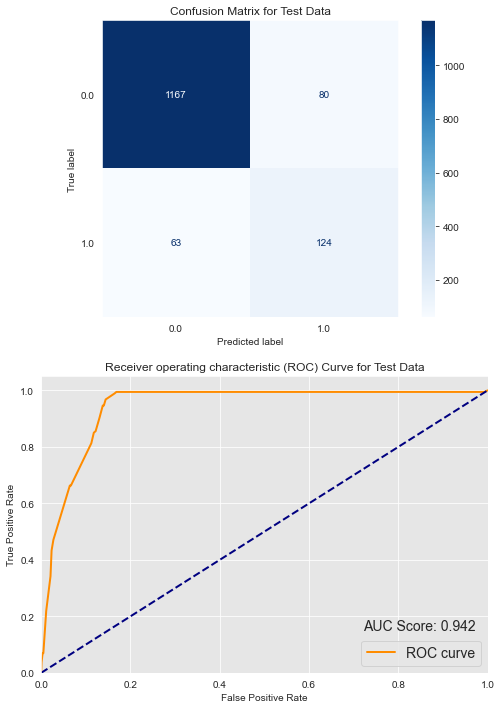

In [102]:
# Decition Tree we worked on together
evaluate(dt_gs, X_train, y_train, X_test, y_test, grid_search=True)

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("S

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Training Metrics
Recall: 0.933
f1: 0.696
----
Testing Metrics
Recall: 0.925
f1: 0.676

Best Parameters for Recall
{'log__C': 0.1, 'log__class_weight': 'balanced', 'log__max_iter': 100, 'log__penalty': 'l2'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__class_weight,param_log__max_iter,param_log__penalty,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
7,0.046600,0.005030,0.007825,0.000537,0.1,balanced,100,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10
9,0.052948,0.004604,0.008846,0.000641,0.1,balanced,1000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10
11,0.045551,0.003176,0.007820,0.000515,0.1,balanced,10000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10
23,0.053313,0.004267,0.007968,0.000851,0.25,balanced,10000,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.920213,...,0.010997,4,0.683794,0.683594,0.707317,0.702479,0.676000,0.690637,0.012076,4
21,0.052966,0.003698,0.007800,0.000747,0.25,balanced,1000,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.920213,...,0.010997,4,0.683794,0.683594,0.707317,0.702479,0.676000,0.690637,0.012076,4
19,0.054631,0.003367,0.007554,0.000367,0.25,balanced,100,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.920213,...,0.010997,4,0.683794,0.683594,0.707317,0.702479,0.676000,0.690637,0.012076,4
45,0.080861,0.004503,0.008471,0.001026,1,balanced,1000,l2,"{'log__C': 1.0, 'log__class_weight': 'balanced...",0.914894,...,0.013165,7,0.683897,0.686391,0.704453,0.703934,0.674747,0.690684,0.011693,1
43,0.075049,0.004659,0.008251,0.000938,1,balanced,100,l2,"{'log__C': 1.0, 'log__class_weight': 'balanced...",0.914894,...,0.013165,7,0.683897,0.686391,0.704453,0.703934,0.674747,0.690684,0.011693,1
35,0.064649,0.004798,0.007653,0.000556,0.5,balanced,10000,l2,"{'log__C': 0.5, 'log__class_weight': 'balanced...",0.914894,...,0.013165,7,0.683897,0.683694,0.704453,0.703934,0.672032,0.689602,0.012666,7
33,0.067842,0.003731,0.008318,0.000846,0.5,balanced,1000,l2,"{'log__C': 0.5, 'log__class_weight': 'balanced...",0.914894,...,0.013165,7,0.683897,0.683694,0.704453,0.703934,0.672032,0.689602,0.012666,7


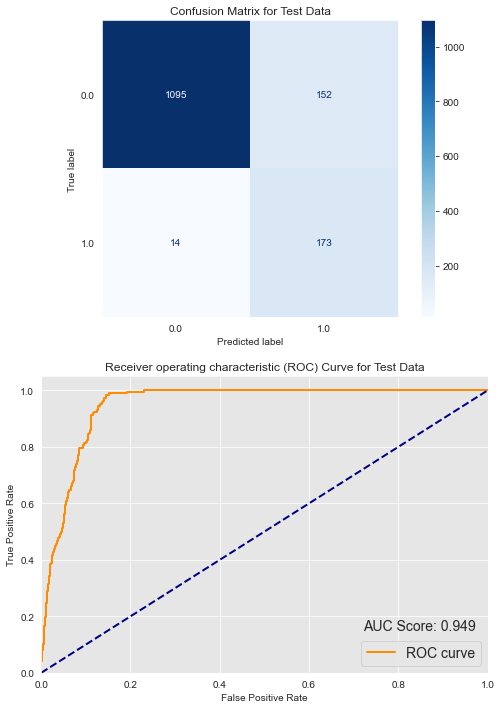

In [103]:
evaluate(log1, X_train, y_train, X_test, y_test, grid_search=True)

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Training Metrics
Recall: 0.933
f1: 0.696
----
Testing Metrics
Recall: 0.925
f1: 0.676

Best Parameters for Recall
{'log__C': 0.1, 'log__class_weight': 'balanced', 'log__max_iter': 100, 'log__penalty': 'l2'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__class_weight,param_log__max_iter,param_log__penalty,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
3,0.050226,0.004481,0.009402,0.001577,0.1,balanced,100,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10
4,0.043589,0.001031,0.008189,0.000922,0.1,balanced,1000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10
5,0.045609,0.003458,0.007969,0.001113,0.1,balanced,10000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.925532,...,0.007378,1,0.681018,0.682261,0.704684,0.703476,0.674603,0.689209,0.012424,10
11,0.053752,0.002804,0.007700,0.000455,0.25,balanced,10000,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.920213,...,0.010997,4,0.683794,0.683594,0.707317,0.702479,0.676000,0.690637,0.012076,4
9,0.055684,0.003800,0.008017,0.000563,0.25,balanced,100,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.920213,...,0.010997,4,0.683794,0.683594,0.707317,0.702479,0.676000,0.690637,0.012076,4
10,0.052656,0.002145,0.007583,0.000417,0.25,balanced,1000,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.920213,...,0.010997,4,0.683794,0.683594,0.707317,0.702479,0.676000,0.690637,0.012076,4
21,0.080495,0.008612,0.008195,0.000668,1,balanced,100,l2,"{'log__C': 1.0, 'log__class_weight': 'balanced...",0.914894,...,0.013165,7,0.683897,0.686391,0.704453,0.703934,0.674747,0.690684,0.011693,1
17,0.067528,0.001544,0.008021,0.000306,0.5,balanced,10000,l2,"{'log__C': 0.5, 'log__class_weight': 'balanced...",0.914894,...,0.013165,7,0.683897,0.683694,0.704453,0.703934,0.672032,0.689602,0.012666,7
16,0.070634,0.004917,0.008389,0.000360,0.5,balanced,1000,l2,"{'log__C': 0.5, 'log__class_weight': 'balanced...",0.914894,...,0.013165,7,0.683897,0.683694,0.704453,0.703934,0.672032,0.689602,0.012666,7
15,0.069254,0.006436,0.008825,0.000986,0.5,balanced,100,l2,"{'log__C': 0.5, 'log__class_weight': 'balanced...",0.914894,...,0.013165,7,0.683897,0.683694,0.704453,0.703934,0.672032,0.689602,0.012666,7


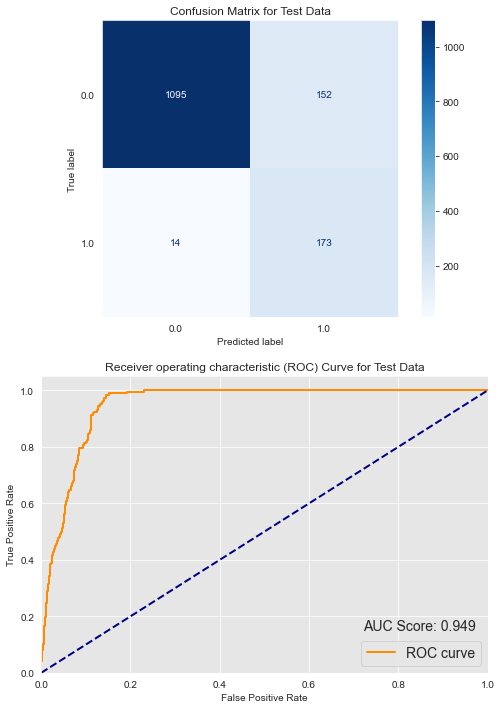

In [104]:
evaluate(log2, X_train, y_train, X_test, y_test, grid_search=True)

Training Metrics
Recall: 0.909
f1: 0.674
----
Testing Metrics
Recall: 0.861
f1: 0.634

Best Parameters for Recall
{'log__C': 1.0, 'log__class_weight': 'balanced', 'log__max_iter': 100, 'log__penalty': 'l2'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__class_weight,param_log__max_iter,param_log__penalty,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
23,0.012837,0.000727,0.003768,0.000323,1,balanced,10000,l2,"{'log__C': 1.0, 'log__class_weight': 'balanced...",0.882979,...,0.016645,1,0.654832,0.657588,0.683694,0.690763,0.664078,0.670191,0.014406,4
21,0.012527,0.000406,0.003753,0.000233,1,balanced,100,l2,"{'log__C': 1.0, 'log__class_weight': 'balanced...",0.882979,...,0.016645,1,0.654832,0.657588,0.683694,0.690763,0.664078,0.670191,0.014406,4
22,0.013135,0.001124,0.003696,0.000183,1,balanced,1000,l2,"{'log__C': 1.0, 'log__class_weight': 'balanced...",0.882979,...,0.016645,1,0.654832,0.657588,0.683694,0.690763,0.664078,0.670191,0.014406,4
17,0.012470,0.000443,0.003722,0.000139,0.5,balanced,10000,l2,"{'log__C': 0.5, 'log__class_weight': 'balanced...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.690763,0.664078,0.669142,0.015439,10
16,0.012407,0.000915,0.003750,0.000327,0.5,balanced,1000,l2,"{'log__C': 0.5, 'log__class_weight': 'balanced...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.690763,0.664078,0.669142,0.015439,10
15,0.012867,0.000836,0.004280,0.000280,0.5,balanced,100,l2,"{'log__C': 0.5, 'log__class_weight': 'balanced...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.690763,0.664078,0.669142,0.015439,10
10,0.012250,0.001120,0.003803,0.000215,0.25,balanced,1000,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.692153,0.664078,0.669420,0.015833,7
9,0.011553,0.000659,0.003585,0.000058,0.25,balanced,100,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.692153,0.664078,0.669420,0.015833,7
11,0.011173,0.000475,0.003631,0.000357,0.25,balanced,10000,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.692153,0.664078,0.669420,0.015833,7
5,0.011315,0.000759,0.003684,0.000094,0.1,balanced,10000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1


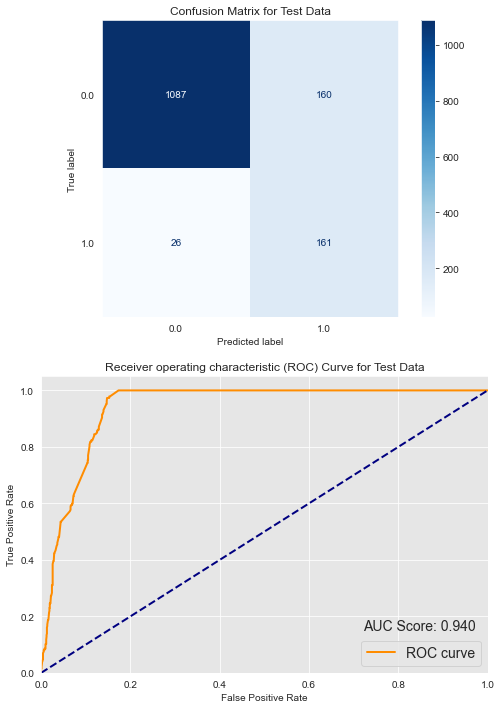

In [140]:
evaluate(log3, threats_train, y_train, threats_test, y_test, grid_search=True)

Training Metrics
Recall: 0.909
f1: 0.674
----
Testing Metrics
Recall: 0.861
f1: 0.634

Best Parameters for Recall
{'log__C': 1.0, 'log__class_weight': 'balanced', 'log__max_iter': 100, 'log__penalty': 'l2'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log__C,param_log__class_weight,param_log__max_iter,param_log__penalty,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
23,0.012484,0.000394,0.003879,0.000181,1,balanced,10000,l2,"{'log__C': 1.0, 'log__class_weight': 'balanced...",0.882979,...,0.016645,1,0.654832,0.657588,0.683694,0.690763,0.664078,0.670191,0.014406,4
21,0.012198,0.000834,0.003676,0.000195,1,balanced,100,l2,"{'log__C': 1.0, 'log__class_weight': 'balanced...",0.882979,...,0.016645,1,0.654832,0.657588,0.683694,0.690763,0.664078,0.670191,0.014406,4
22,0.012486,0.000422,0.003768,0.000399,1,balanced,1000,l2,"{'log__C': 1.0, 'log__class_weight': 'balanced...",0.882979,...,0.016645,1,0.654832,0.657588,0.683694,0.690763,0.664078,0.670191,0.014406,4
17,0.012358,0.000540,0.003532,0.000177,0.5,balanced,10000,l2,"{'log__C': 0.5, 'log__class_weight': 'balanced...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.690763,0.664078,0.669142,0.015439,10
16,0.011907,0.000506,0.003852,0.000299,0.5,balanced,1000,l2,"{'log__C': 0.5, 'log__class_weight': 'balanced...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.690763,0.664078,0.669142,0.015439,10
15,0.012772,0.001397,0.003612,0.000346,0.5,balanced,100,l2,"{'log__C': 0.5, 'log__class_weight': 'balanced...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.690763,0.664078,0.669142,0.015439,10
10,0.013217,0.001303,0.004227,0.000253,0.25,balanced,1000,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.692153,0.664078,0.669420,0.015833,7
9,0.014600,0.000304,0.004725,0.000777,0.25,balanced,100,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.692153,0.664078,0.669420,0.015833,7
11,0.012009,0.000729,0.003846,0.000268,0.25,balanced,10000,l2,"{'log__C': 0.25, 'log__class_weight': 'balance...",0.882979,...,0.018422,4,0.654832,0.652344,0.683694,0.692153,0.664078,0.669420,0.015833,7
5,0.012778,0.000454,0.004334,0.000389,0.1,balanced,10000,l2,"{'log__C': 0.1, 'log__class_weight': 'balanced...",0.882979,...,0.017269,10,0.653543,0.648438,0.694949,0.690763,0.665370,0.670613,0.019021,1


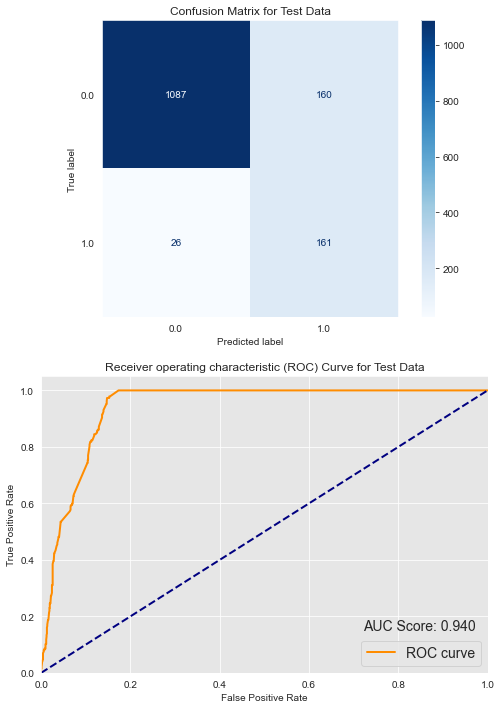

In [141]:
evaluate(log4, threats_train, y_train, threats_test, y_test, grid_search=True)

Training Metrics
Recall: 0.832
f1: 0.890
----
Testing Metrics
Recall: 0.567
f1: 0.637

Best Parameters for Recall
{'for__criterion': 'gini', 'for__max_depth': 10, 'for__n_estimators': 1000}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_for__criterion,param_for__max_depth,param_for__n_estimators,params,split0_test_recall,split1_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
8,3.908856,0.051035,0.183990,0.006153,gini,10,1000,"{'for__criterion': 'gini', 'for__max_depth': 1...",0.590426,0.595745,...,0.007536,1,0.641618,0.641834,0.662791,0.634006,0.656891,0.647428,0.010684,1
17,3.650446,0.055038,0.161788,0.001369,entropy,10,1000,"{'for__criterion': 'entropy', 'for__max_depth'...",0.579787,0.590426,...,0.016160,2,0.643068,0.636103,0.662757,0.615836,0.660819,0.643716,0.017267,2
16,0.389508,0.016163,0.025502,0.001781,entropy,10,100,"{'for__criterion': 'entropy', 'for__max_depth'...",0.563830,0.611702,...,0.031468,3,0.623529,0.660920,0.655072,0.600601,0.668605,0.641745,0.025657,3
7,0.376471,0.013529,0.024202,0.001034,gini,10,100,"{'for__criterion': 'gini', 'for__max_depth': 1...",0.574468,0.601064,...,0.023146,4,0.637168,0.651297,0.651026,0.597015,0.639296,0.635160,0.019942,4
15,0.056947,0.002275,0.011034,0.000388,entropy,10,10,"{'for__criterion': 'entropy', 'for__max_depth'...",0.563830,0.553191,...,0.030775,5,0.646341,0.601156,0.581818,0.645892,0.644377,0.623917,0.027184,5
6,0.055538,0.002881,0.010587,0.000407,gini,10,10,"{'for__criterion': 'gini', 'for__max_depth': 1...",0.553191,0.569149,...,0.039646,6,0.602899,0.591160,0.615385,0.599440,0.554140,0.592605,0.020752,6
4,0.298003,0.024025,0.023265,0.001362,gini,5,100,"{'for__criterion': 'gini', 'for__max_depth': 5...",0.367021,0.361702,...,0.023928,7,0.505495,0.498168,0.417910,0.461538,0.470149,0.470652,0.031100,7
12,0.046247,0.001608,0.010561,0.000850,entropy,5,10,"{'for__criterion': 'entropy', 'for__max_depth'...",0.313830,0.335106,...,0.015592,8,0.441948,0.461538,0.459259,0.428016,0.433460,0.444844,0.013474,9
5,2.827851,0.170229,0.141296,0.008417,gini,5,1000,"{'for__criterion': 'gini', 'for__max_depth': 5...",0.324468,0.335106,...,0.020031,9,0.465649,0.468401,0.455882,0.409266,0.435798,0.446999,0.022064,8
3,0.045000,0.001592,0.010923,0.000676,gini,5,10,"{'for__criterion': 'gini', 'for__max_depth': 5...",0.260638,0.409574,...,0.061436,10,0.393574,0.522034,0.445283,0.434783,0.349593,0.429053,0.057470,11


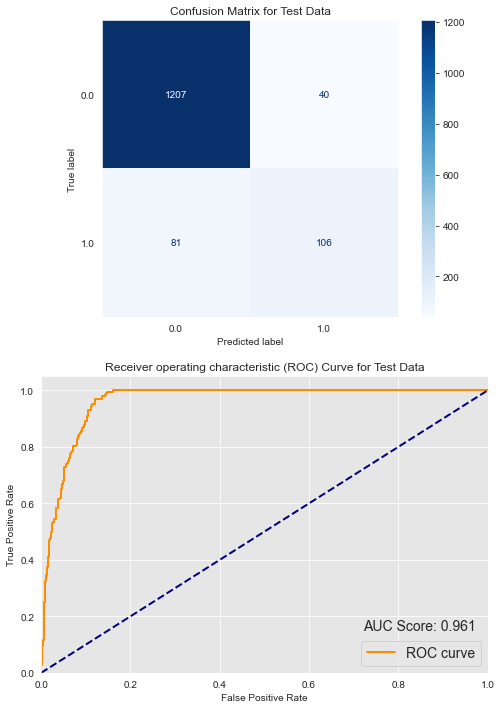

In [107]:
evaluate(for1, X_train, y_train, X_test, y_test, grid_search=True)

Training Metrics
Recall: 0.990
f1: 0.994
----
Testing Metrics
Recall: 0.583
f1: 0.618

Best Parameters for Recall
{'for__criterion': 'gini', 'for__max_depth': 100, 'for__min_samples_split': 5, 'for__n_estimators': 1000}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_for__criterion,param_for__max_depth,param_for__min_samples_split,param_for__n_estimators,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
41,4.037452,0.076201,0.186607,0.004450,gini,100,5,1000,"{'for__criterion': 'gini', 'for__max_depth': 1...",0.648936,...,0.007496,1,0.672176,0.661247,0.685083,0.664820,0.689076,0.674480,0.010947,1
44,3.832855,0.009913,0.180297,0.003256,gini,100,10,1000,"{'for__criterion': 'gini', 'for__max_depth': 1...",0.622340,...,0.017040,2,0.646409,0.652291,0.692521,0.661111,0.694678,0.669402,0.020315,7
35,3.842886,0.042124,0.179627,0.002632,gini,50,10,1000,"{'for__criterion': 'gini', 'for__max_depth': 5...",0.654255,...,0.010855,3,0.668478,0.666667,0.679666,0.655462,0.685552,0.671165,0.010519,4
89,3.953701,0.055776,0.178246,0.002727,entropy,100,10,1000,"{'for__criterion': 'entropy', 'for__max_depth'...",0.627660,...,0.014140,4,0.653740,0.654155,0.688889,0.662921,0.692958,0.670533,0.017018,5
32,3.997136,0.014873,0.183211,0.001484,gini,50,5,1000,"{'for__criterion': 'gini', 'for__max_depth': 5...",0.643617,...,0.011905,5,0.670360,0.657609,0.677871,0.653631,0.692737,0.670442,0.014139,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,1.730471,0.011621,0.112749,0.001850,gini,2,5,1000,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.000000,...,0.002613,82,0.000000,0.010582,0.000000,0.000000,0.010638,0.004244,0.005198,82
4,0.189723,0.003987,0.018816,0.000542,gini,2,5,100,"{'for__criterion': 'gini', 'for__max_depth': 2...",0.000000,...,0.002613,82,0.000000,0.010582,0.000000,0.000000,0.010638,0.004244,0.005198,82
49,0.189861,0.003216,0.018398,0.000392,entropy,2,5,100,"{'for__criterion': 'entropy', 'for__max_depth'...",0.005319,...,0.002606,88,0.010582,0.010582,0.000000,0.000000,0.000000,0.004233,0.005184,88
47,1.757004,0.009421,0.112336,0.001130,entropy,2,2,1000,"{'for__criterion': 'entropy', 'for__max_depth'...",0.000000,...,0.002139,89,0.000000,0.000000,0.000000,0.000000,0.010638,0.002128,0.004255,89


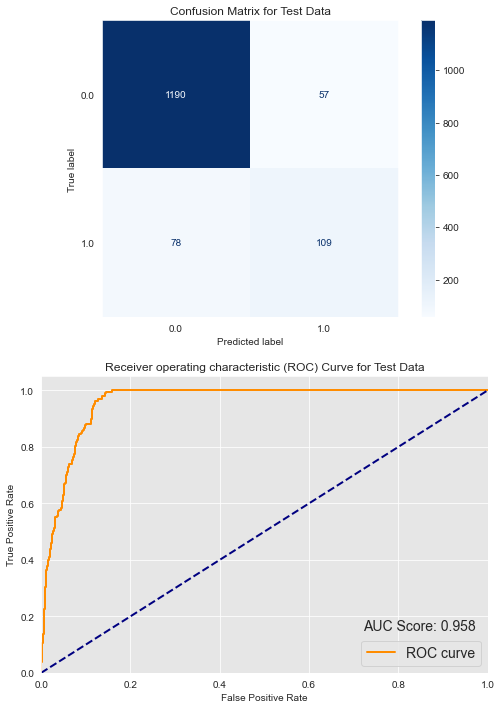

In [108]:
evaluate(for2, X_train, y_train, X_test, y_test, grid_search=True)

Training Metrics
Recall: 0.994
f1: 0.991
----
Testing Metrics
Recall: 0.545
f1: 0.575

Best Parameters for Recall
{'bag__base_estimator': DecisionTreeClassifier(), 'bag__bootstrap': True, 'bag__bootstrap_features': False, 'bag__n_estimators': 15}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bag__base_estimator,param_bag__bootstrap,param_bag__bootstrap_features,param_bag__n_estimators,params,split0_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
6,0.281514,0.014178,0.015182,0.001035,DecisionTreeClassifier(),True,False,15,{'bag__base_estimator': DecisionTreeClassifier...,0.696809,...,0.025996,1,0.678756,0.613757,0.650794,0.641711,0.657754,0.648554,0.021258,1
7,0.369102,0.039451,0.015895,0.000921,DecisionTreeClassifier(),True,False,20,{'bag__base_estimator': DecisionTreeClassifier...,0.648936,...,0.014649,2,0.642105,0.612137,0.622590,0.632432,0.644444,0.630742,0.012102,2
4,0.106729,0.006074,0.011451,0.000194,DecisionTreeClassifier(),True,False,5,{'bag__base_estimator': DecisionTreeClassifier...,0.670213,...,0.038698,3,0.656250,0.605744,0.574526,0.600000,0.629921,0.613288,0.027779,4
2,0.382927,0.025244,0.016398,0.001204,DecisionTreeClassifier(),True,True,15,{'bag__base_estimator': DecisionTreeClassifier...,0.622340,...,0.031086,4,0.646409,0.606742,0.604651,0.634831,0.652174,0.628961,0.019811,3
14,0.449820,0.028684,0.015832,0.000825,DecisionTreeClassifier(),False,False,15,{'bag__base_estimator': DecisionTreeClassifier...,0.590426,...,0.022361,5,0.578125,0.550649,0.594595,0.594315,0.564384,0.576414,0.017102,12
13,0.311618,0.036534,0.015299,0.003208,DecisionTreeClassifier(),False,False,10,{'bag__base_estimator': DecisionTreeClassifier...,0.574468,...,0.030500,6,0.579088,0.550265,0.582210,0.606218,0.561798,0.575916,0.019106,13
12,0.159065,0.008719,0.011234,0.000717,DecisionTreeClassifier(),False,False,5,{'bag__base_estimator': DecisionTreeClassifier...,0.585106,...,0.023002,7,0.578947,0.547872,0.577657,0.589147,0.570637,0.572852,0.013818,14
15,0.545566,0.047196,0.015831,0.000515,DecisionTreeClassifier(),False,False,20,{'bag__base_estimator': DecisionTreeClassifier...,0.569149,...,0.024710,8,0.564644,0.547872,0.595745,0.587927,0.564246,0.572087,0.017400,15
10,0.534828,0.019631,0.016139,0.000482,DecisionTreeClassifier(),False,True,15,{'bag__base_estimator': DecisionTreeClassifier...,0.627660,...,0.034814,9,0.644809,0.601626,0.605341,0.589888,0.568966,0.602126,0.024827,6
8,0.195629,0.020398,0.010611,0.000647,DecisionTreeClassifier(),False,True,5,{'bag__base_estimator': DecisionTreeClassifier...,0.531915,...,0.038714,10,0.571429,0.621253,0.599440,0.548105,0.613260,0.590697,0.027220,9


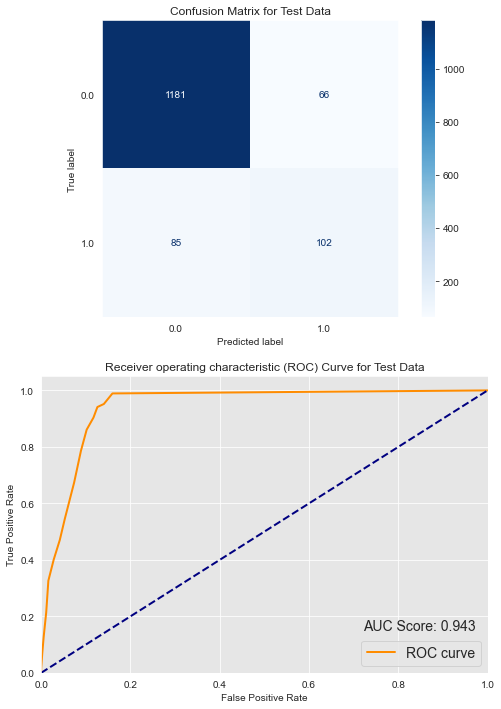

In [109]:
evaluate(bag1, X_train, y_train, X_test, y_test, grid_search=True)

Training Metrics
Recall: 0.000
f1: 0.000
----
Testing Metrics
Recall: 0.000
f1: 0.000

Best Parameters for Recall
{'bag__base_estimator': DecisionTreeClassifier(), 'bag__bootstrap': True, 'bag__bootstrap_features': False, 'bag__max_features': 1, 'bag__max_samples': 1, 'bag__n_estimators': 5}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bag__base_estimator,param_bag__bootstrap,param_bag__bootstrap_features,param_bag__max_features,param_bag__max_samples,param_bag__n_estimators,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
36,0.023250,0.001073,0.008926,0.000398,DecisionTreeClassifier(),True,False,1,1,5,...,0.400000,1,0.000000,0.000000,0.000000,0.000000,0.230864,0.046173,0.092346,6
68,0.023624,0.000424,0.008025,0.000202,DecisionTreeClassifier(),True,False,10,10,5,...,0.072998,2,0.000000,0.040816,0.280576,0.147465,0.156522,0.125076,0.098401,1
141,0.029562,0.000310,0.008358,0.000107,DecisionTreeClassifier(),False,False,10,10,10,...,0.092601,3,0.000000,0.010582,0.345098,0.021164,0.000000,0.075369,0.135093,2
136,0.021982,0.000194,0.007702,0.000081,DecisionTreeClassifier(),False,False,10,5,5,...,0.051127,4,0.186567,0.041026,0.000000,0.010101,0.000000,0.047539,0.071124,4
92,0.022325,0.001074,0.008147,0.000186,DecisionTreeClassifier(),False,True,5,10,5,...,0.052179,5,0.010526,0.218341,0.000000,0.010417,0.000000,0.047857,0.085370,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,0.053777,0.004524,0.014619,0.001721,DecisionTreeClassifier(),True,False,1,5,20,...,0.000000,37,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37
42,0.039276,0.001699,0.010779,0.000402,DecisionTreeClassifier(),True,False,1,5,15,...,0.000000,37,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37
41,0.033114,0.003457,0.010255,0.000249,DecisionTreeClassifier(),True,False,1,5,10,...,0.000000,37,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37
59,0.043189,0.000308,0.010317,0.000346,DecisionTreeClassifier(),True,False,5,10,20,...,0.000000,37,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,37


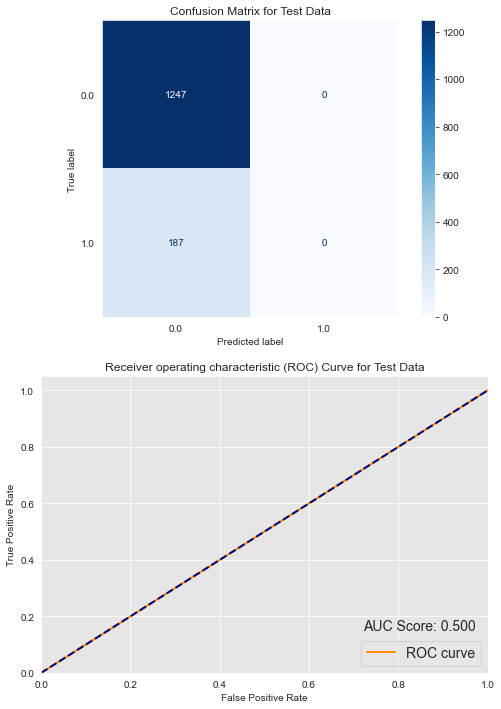

In [110]:
evaluate(bag2, X_train, y_train, X_test, y_test, grid_search=True)

Training Metrics
Recall: 0.824
f1: 0.621
----
Testing Metrics
Recall: 0.727
f1: 0.576

Best Parameters for Recall
{'gnb__priors': None}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gnb__priors,params,split0_test_recall,split1_test_recall,split2_test_recall,split3_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.021306,0.001157,0.008637,0.000456,None,{'gnb__priors': None},0.840426,0.81383,0.705882,0.775401,...,0.069116,1,0.598485,0.616935,0.631579,0.614407,0.589655,0.610212,0.014693,1


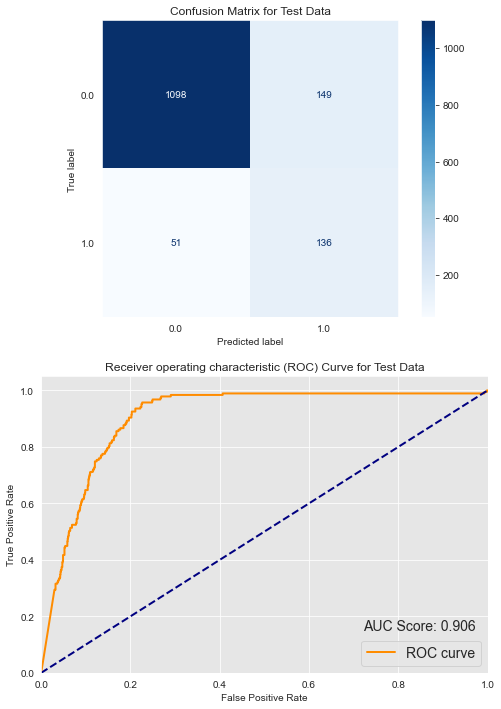

In [111]:
evaluate(gnb_gs, X_train, y_train, X_test, y_test, grid_search=True)

Training Metrics
Recall: 0.952
f1: 0.669
----
Testing Metrics
Recall: 0.930
f1: 0.643

Best Parameters for Recall
{'mnb__alpha': 1.0, 'mnb__fit_prior': False}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_mnb__alpha,param_mnb__fit_prior,params,split0_test_recall,split1_test_recall,split2_test_recall,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
1,0.020021,0.001349,0.009365,0.001223,1,False,"{'mnb__alpha': 1.0, 'mnb__fit_prior': False}",0.962766,0.941489,0.957219,...,0.011196,1,0.656987,0.657993,0.675472,0.674374,0.671642,0.667293,0.008107,1
0,0.026524,0.004036,0.013815,0.003232,1,True,"{'mnb__alpha': 1.0, 'mnb__fit_prior': True}",0.813830,0.760638,0.807487,...,0.020594,2,0.660907,0.655963,0.691076,0.665127,0.656250,0.665865,0.013048,2


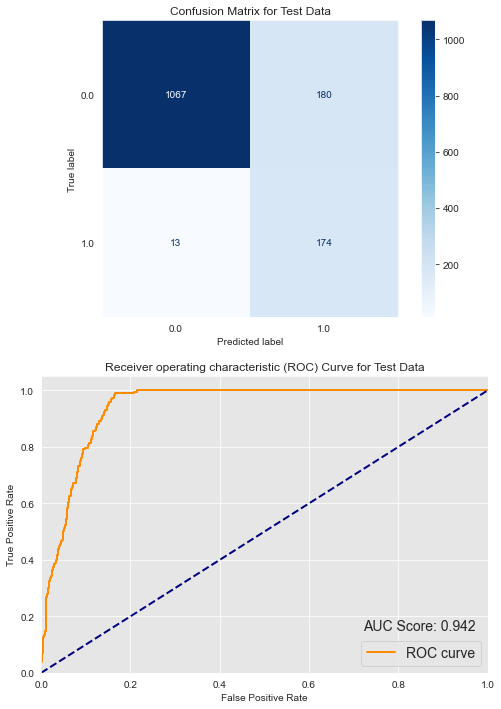

In [138]:
evaluate(mnb_gs, X_train, y_train, X_test, y_test, grid_search=True)

Training Metrics
Recall: 0.682
f1: 0.671
----
Testing Metrics
Recall: 0.642
f1: 0.623

Best Parameters for Recall
{'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 10, 'xgb__subsample': 0.5}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_weight,param_xgb__n_estimators,param_xgb__subsample,params,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
0,0.062823,0.012255,0.011494,0.000566,0.1,3,1,10,0.5,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.023950,1,0.670241,0.681818,0.644330,0.670130,0.692308,0.671765,0.016005,7
6,0.056934,0.002014,0.011299,0.000373,0.1,3,2,10,0.5,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.027596,2,0.663073,0.681818,0.640827,0.670130,0.692308,0.669631,0.017525,11
36,0.065341,0.000562,0.012817,0.000222,0.2,3,1,10,0.5,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.037704,3,0.652632,0.686131,0.653951,0.686170,0.704000,0.676577,0.020103,1
42,0.065487,0.000628,0.012879,0.000429,0.2,3,2,10,0.5,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.033307,4,0.654354,0.679803,0.653951,0.693122,0.700265,0.676299,0.019239,2
66,0.094366,0.001811,0.013285,0.000402,0.2,10,2,10,0.5,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.015887,5,0.664908,0.645995,0.684636,0.693333,0.659401,0.669654,0.017162,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52,0.501034,0.006910,0.014271,0.000114,0.2,5,1,100,0.5,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.020556,68,0.620690,0.645161,0.632768,0.668508,0.663073,0.646040,0.017969,67
62,0.436349,0.040651,0.014064,0.000697,0.2,10,1,50,0.5,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.026947,69,0.640000,0.609626,0.675603,0.632768,0.659341,0.643468,0.022612,69
63,0.522309,0.049315,0.014689,0.001236,0.2,10,1,50,0.7,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.030071,70,0.643617,0.654255,0.628415,0.605042,0.666667,0.639599,0.021368,71
64,1.029904,0.133284,0.015687,0.001379,0.2,10,1,100,0.5,"{'xgb__learning_rate': 0.2, 'xgb__max_depth': ...",...,0.020867,71,0.642105,0.608696,0.655827,0.641304,0.629834,0.635553,0.015755,72


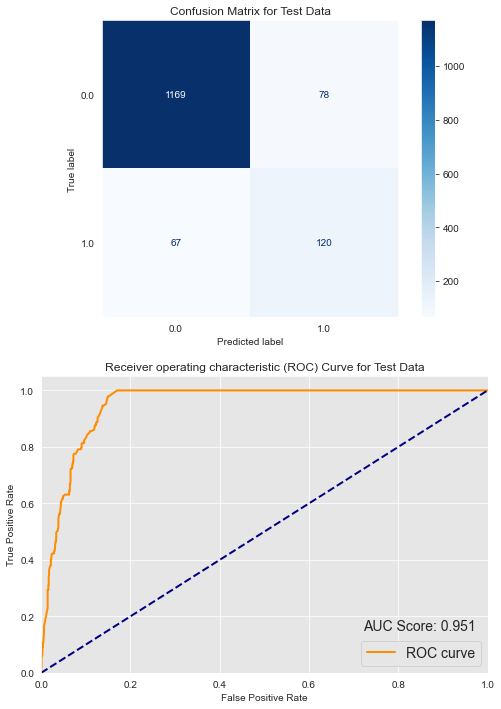

In [114]:
evaluate(xgb_gs1, X_train, y_train, X_test, y_test, grid_search=True)

Training Metrics
Recall: 0.780
f1: 0.630
----
Testing Metrics
Recall: 0.749
f1: 0.596

Best Parameters for Recall
{'xgb__learning_rate': 0.05, 'xgb__max_depth': 1, 'xgb__min_child_weight': 0, 'xgb__n_estimators': 1, 'xgb__subsample': 0.5}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__min_child_weight,param_xgb__n_estimators,param_xgb__subsample,params,...,std_test_recall,rank_test_recall,split0_test_f1,split1_test_f1,split2_test_f1,split3_test_f1,split4_test_f1,mean_test_f1,std_test_f1,rank_test_f1
109,0.033936,0.000071,0.012221,0.000073,0.05,1,0,1,0.5,"{'xgb__learning_rate': 0.05, 'xgb__max_depth':...",...,0.006138,1,0.621564,0.626609,0.641593,0.635193,0.62635,0.630262,0.007169,110
242,0.032591,0.000277,0.011572,0.000069,0.1,1,2,1,0.7,"{'xgb__learning_rate': 0.1, 'xgb__max_depth': ...",...,0.006138,1,0.621564,0.626609,0.641593,0.635193,0.62635,0.630262,0.007169,110
125,0.035286,0.000478,0.011900,0.000399,0.05,1,1,3,0.7,"{'xgb__learning_rate': 0.05, 'xgb__max_depth':...",...,0.006138,1,0.621564,0.626609,0.641593,0.635193,0.62635,0.630262,0.007169,110
124,0.034894,0.000168,0.011592,0.000031,0.05,1,1,3,0.5,"{'xgb__learning_rate': 0.05, 'xgb__max_depth':...",...,0.006138,1,0.621564,0.626609,0.641593,0.635193,0.62635,0.630262,0.007169,110
122,0.032289,0.000116,0.011548,0.000070,0.05,1,1,1,0.7,"{'xgb__learning_rate': 0.05, 'xgb__max_depth':...",...,0.006138,1,0.621564,0.626609,0.641593,0.635193,0.62635,0.630262,0.007169,110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53,0.040235,0.000293,0.011840,0.000149,0,3,1,3,0.7,"{'xgb__learning_rate': 0.0, 'xgb__max_depth': ...",...,0.000000,217,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,217
52,0.040552,0.000472,0.011994,0.000124,0,3,1,3,0.5,"{'xgb__learning_rate': 0.0, 'xgb__max_depth': ...",...,0.000000,217,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,217
51,0.039421,0.000136,0.012108,0.000116,0,3,1,3,0.3,"{'xgb__learning_rate': 0.0, 'xgb__max_depth': ...",...,0.000000,217,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,217
58,0.058723,0.000260,0.011938,0.000267,0,3,1,10,0.5,"{'xgb__learning_rate': 0.0, 'xgb__max_depth': ...",...,0.000000,217,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,217


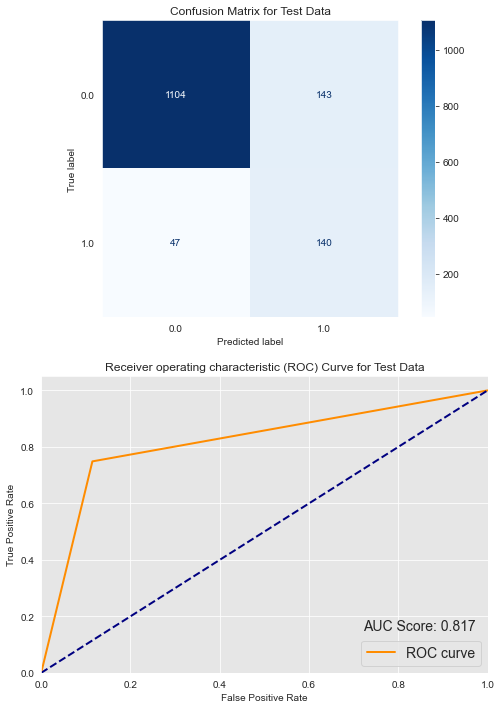

In [115]:
evaluate(xgb_gs2, X_train, y_train, X_test, y_test, grid_search=True)